In [1]:
# ====================================================================
# 1. IMPORTATIONS ET FONCTIONS UTILITAIRES
# ====================================================================
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from contextlib import contextmanager
from lightgbm import LGBMClassifier, early_stopping

import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import mlflow
import mlflow.lightgbm
from sklearn.metrics import confusion_matrix, roc_auc_score
import gc
from sklearn.model_selection import StratifiedKFold, KFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

warnings.simplefilter(action='ignore')

@contextmanager
def timer(title):
    """Fonction utilitaire pour mesurer le temps d'exécution d'un bloc."""
    t0 = time.time()
    yield
    print(f"{title} - fait en {time.time() - t0:.0f}s")

def one_hot_encoder(df, nan_as_category=True):
    """Encode les variables catégorielles en one-hot."""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [2]:
# ====================================================================
# 2. FONCTION DE MODÉLISATION
# ====================================================================

def kfold_logistic_regression(df, num_folds, stratified=False, debug=False):
    """Exécute un modèle de régression logistique avec validation croisée K-Fold et MLflow."""

    # Séparez les données d'entraînement et de test
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Début de la régression logistique. Shape entraînement: {train_df.shape}, Shape test: {test_df.shape}")
    del df
    gc.collect()

    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Démarrez une nouvelle exécution (run) MLflow
    with mlflow.start_run():

        # Définissez les paramètres du modèle de régression logistique
        lr_params = {
            'solver': 'liblinear',
            'random_state': 42
        }
        mlflow.log_params(lr_params)

        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(**lr_params))
        ])

        print(f'Entraînement avec {num_folds} folds')
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
            train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
            valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

            pipeline.fit(train_x, train_y)
            oof_preds[valid_idx] = pipeline.predict_proba(valid_x)[:, 1]

            fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
            print(f'Fold {n_fold + 1} AUC : {fold_auc:.6f}')

            # Enregistrez le score AUC de chaque fold avec MLflow
            mlflow.log_metric(f"auc_fold_{n_fold+1}", fold_auc)

        full_auc_score = roc_auc_score(train_df['TARGET'], oof_preds)
        print(f'Score AUC complet : {full_auc_score:.6f}')

        # Enregistrez le score AUC final avec MLflow
        mlflow.log_metric("auc_overall", full_auc_score)

        # Enregistrez le modèle entier avec MLflow
        mlflow.sklearn.log_model(pipeline, "logistic_regression_model")

    return full_auc_score

# ====================================================================

def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    """
    Exécute un modèle LightGBM avec validation croisée,
    calcule un score métier et enregistre les résultats dans MLflow.
    """
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()

    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    # Démarrez une nouvelle exécution MLflow pour l'expérience LightGBM
    with mlflow.start_run(run_name="LightGBM_Modelisation_V2_Balanced"):

        # Définissez vos coûts métier ici
        cout_fp = 1    # Hypothèse : coût d'un faux positif
        cout_fn = 10   # Hypothèse : coût d'un faux négatif (10x plus élevé)

        # Enregistrez les paramètres de coût dans MLflow
        mlflow.log_param("cout_fp", cout_fp)
        mlflow.log_param("cout_fn", cout_fn)

        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
            train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
            valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

            clf = LGBMClassifier(
                nthread=4, n_estimators=10000, learning_rate=0.02, num_leaves=34,
                colsample_bytree=0.9497036, subsample=0.8715623, max_depth=8,
                reg_alpha=0.041545473, reg_lambda=0.0735294, min_split_gain=0.0222415,
                min_child_weight=39.3259775, silent=-1, verbose=-1, class_weight='balanced',
            )
            # Votre code initial pour LightGBM est correct, mais il peut y avoir une erreur avec 'silent' et 'verbose'
            # Je les ai commentés pour la démonstration.
            # clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
            #     eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

            clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],
                    eval_metric='auc',
                    callbacks=[early_stopping(stopping_rounds=200, verbose=False)])

            # Prédire les probabilités sur les données de validation
            oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]

            # --- NOUVEAU BLOC DE CODE POUR LE SCORE MÉTIER ---
            meilleur_cout_fold = float('inf')
            seuil_optimal_fold = 0.0

            # Testez différents seuils de probabilité pour trouver le meilleur coût métier
            for seuil in np.arange(0.01, 1.0, 0.01):
                y_pred_seuil = (oof_preds[valid_idx] > seuil).astype(int)
                cout_actuel = score_metier(valid_y, y_pred_seuil, cout_fp, cout_fn)

                if cout_actuel < meilleur_cout_fold:
                    meilleur_cout_fold = cout_actuel
                    seuil_optimal_fold = seuil

            mlflow.log_metric(f"auc_fold_{n_fold+1}", roc_auc_score(valid_y, oof_preds[valid_idx]))
            mlflow.log_metric(f"cout_metier_fold_{n_fold+1}", meilleur_cout_fold)
            mlflow.log_metric(f"seuil_optimal_fold_{n_fold+1}", seuil_optimal_fold)
            print('Fold %2d AUC : %.6f, Coût Métier Min : %.2f à un seuil de %.2f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]), meilleur_cout_fold, seuil_optimal_fold))

            sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

            # ... (code pour l'importance des caractéristiques, inchangé)
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            del train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
        # Enregistrez le score AUC final dans MLflow
        mlflow.log_metric("auc_overall", roc_auc_score(train_df['TARGET'], oof_preds))

        # Enregistrez le modèle entier avec MLflow
        mlflow.lightgbm.log_model(clf, "lightgbm_model")

    display_importances(feature_importance_df, "LightGBM")
    return feature_importance_df

# ====================================================================

def kfold_xgboost(df, num_folds, stratified=False, debug=False):
    """
    Exécute un modèle XGBoost avec validation croisée,
    calcule un score métier et enregistre les résultats dans MLflow.
    """
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting XGBoost. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()

    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Démarrez une nouvelle exécution MLflow pour l'expérience XGBoost
    with mlflow.start_run(run_name="XGBoost_Modelisation_V1_Opti"):

        # Définissez vos coûts métier ici
        cout_fp = 1
        cout_fn = 10
        mlflow.log_param("cout_fp", cout_fp)
        mlflow.log_param("cout_fn", cout_fn)

        # Calculez le poids pour la gestion du déséquilibre des classes
        ratio_desequilibre = np.sum(train_df['TARGET'] == 0) / np.sum(train_df['TARGET'] == 1)
        mlflow.log_param("scale_pos_weight", ratio_desequilibre)

        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
            train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
            valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

            # Modèle XGBoost
            clf = xgb.XGBClassifier(
                objective='binary:logistic',
                n_estimators=300,
                learning_rate=0.05,
                max_depth=3,
                scale_pos_weight=ratio_desequilibre,
                n_jobs=-1,
                eval_metric='auc',
                use_label_encoder=False,
                random_state=42
            )

            # L'arrêt précoce est retiré, le modèle s'entraîne sur 100 estimateurs
            clf.fit(
                train_x, train_y,
                eval_set=[(valid_x, valid_y)],
                verbose=False
            )

            # Remplacement de 'best_iteration' par 'n_estimators'
            oof_preds[valid_idx] = clf.predict_proba(valid_x, iteration_range=(0, clf.n_estimators))[:, 1]
            sub_preds += clf.predict_proba(test_df[feats], iteration_range=(0, clf.n_estimators))[:, 1] / folds.n_splits

            meilleur_cout_fold = float('inf')
            seuil_optimal_fold = 0.0

            for seuil in np.arange(0.01, 1.0, 0.01):
                y_pred_seuil = (oof_preds[valid_idx] > seuil).astype(int)
                cout_actuel = score_metier(valid_y, y_pred_seuil, cout_fp, cout_fn)
                if cout_actuel < meilleur_cout_fold:
                    meilleur_cout_fold = cout_actuel
                    seuil_optimal_fold = seuil

            mlflow.log_metric(f"auc_fold_{n_fold+1}", roc_auc_score(valid_y, oof_preds[valid_idx]))
            mlflow.log_metric(f"cout_metier_fold_{n_fold+1}", meilleur_cout_fold)
            mlflow.log_metric(f"seuil_optimal_fold_{n_fold+1}", seuil_optimal_fold)
            print('Fold %2d AUC : %.6f, Coût Métier Min : %.2f à un seuil de %.2f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]), meilleur_cout_fold, seuil_optimal_fold))

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            del train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
        mlflow.log_metric("auc_overall", roc_auc_score(train_df['TARGET'], oof_preds))
        mlflow.xgboost.log_model(clf, "xgboost_model")

    display_importances(feature_importance_df, "XGBoost_V1_Opti")
    return feature_importance_df

# ====================================================================

def kfold_random_forest(df, num_folds, stratified=False, debug=False):
    """
    Exécute un modèle Random Forest avec validation croisée,
    calcule un score métier et enregistre les résultats dans MLflow.
    """
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting Random Forest. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()

    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Démarrez une nouvelle exécution MLflow pour l'expérience Random Forest
    with mlflow.start_run(run_name="RandomForest_Modelisation_V1_Opti"):

        # Définissez vos coûts métier ici
        cout_fp = 1
        cout_fn = 10
        mlflow.log_param("cout_fp", cout_fp)
        mlflow.log_param("cout_fn", cout_fn)

        # Définissez les hyperparamètres du modèle
        rf_params = {
            'n_estimators': 200,
            'max_depth': 15,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'class_weight': 'balanced',  # Gère le déséquilibre des classes
            'random_state': 42,
            'n_jobs': -1  # Utilise tous les cœurs disponibles
        }
        mlflow.log_params(rf_params)

        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
            train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
            valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

            # Instanciez le modèle Random Forest
            clf = RandomForestClassifier(**rf_params)

            clf.fit(train_x, train_y)

            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

            meilleur_cout_fold = float('inf')
            seuil_optimal_fold = 0.0

            for seuil in np.arange(0.01, 1.0, 0.01):
                y_pred_seuil = (oof_preds[valid_idx] > seuil).astype(int)
                cout_actuel = score_metier(valid_y, y_pred_seuil, cout_fp, cout_fn)
                if cout_actuel < meilleur_cout_fold:
                    meilleur_cout_fold = cout_actuel
                    seuil_optimal_fold = seuil

            mlflow.log_metric(f"auc_fold_{n_fold+1}", roc_auc_score(valid_y, oof_preds[valid_idx]))
            mlflow.log_metric(f"cout_metier_fold_{n_fold+1}", meilleur_cout_fold)
            mlflow.log_metric(f"seuil_optimal_fold_{n_fold+1}", seuil_optimal_fold)
            print('Fold %2d AUC : %.6f, Coût Métier Min : %.2f à un seuil de %.2f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]), meilleur_cout_fold, seuil_optimal_fold))

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            del train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
        mlflow.log_metric("auc_overall", roc_auc_score(train_df['TARGET'], oof_preds))
        mlflow.sklearn.log_model(clf, "random_forest_model")

    display_importances(feature_importance_df, "RandomForest_V1_Opti")
    return feature_importance_df

# ====================================================================

def score_metier(y_true, y_pred, cout_fp, cout_fn):
    """Calcule le coût métier à partir de la matrice de confusion."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cout_total = (fp * cout_fp) + (fn * cout_fn)
    return cout_total

def display_importances(feature_importance_df_, name):
    """Affiche/trace l'importance des features."""
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{name} Features (moyenne sur les folds)')
    plt.tight_layout()
    plt.savefig(f'{name}_Importances.png')

Chargement du DataFrame à partir de 'final_dataset.parquet'


2025/08/12 17:40:31 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Starting Random Forest. Train shape: (307507, 799), test shape: (48744, 799)
Fold  1 AUC : 0.755843, Coût Métier Min : 32923.00 à un seuil de 0.36
Fold  2 AUC : 0.750345, Coût Métier Min : 33106.00 à un seuil de 0.33
Fold  3 AUC : 0.749733, Coût Métier Min : 32639.00 à un seuil de 0.35
Fold  4 AUC : 0.749699, Coût Métier Min : 33162.00 à un seuil de 0.34
Fold  5 AUC : 0.755697, Coût Métier Min : 32402.00 à un seuil de 0.34
Full AUC score 0.752246


2025/08/12 17:46:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 17:47:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Execution de RandomForest avec kfold, score métier et MLflow - fait en 393s
Exécution complète du modèle - fait en 393s


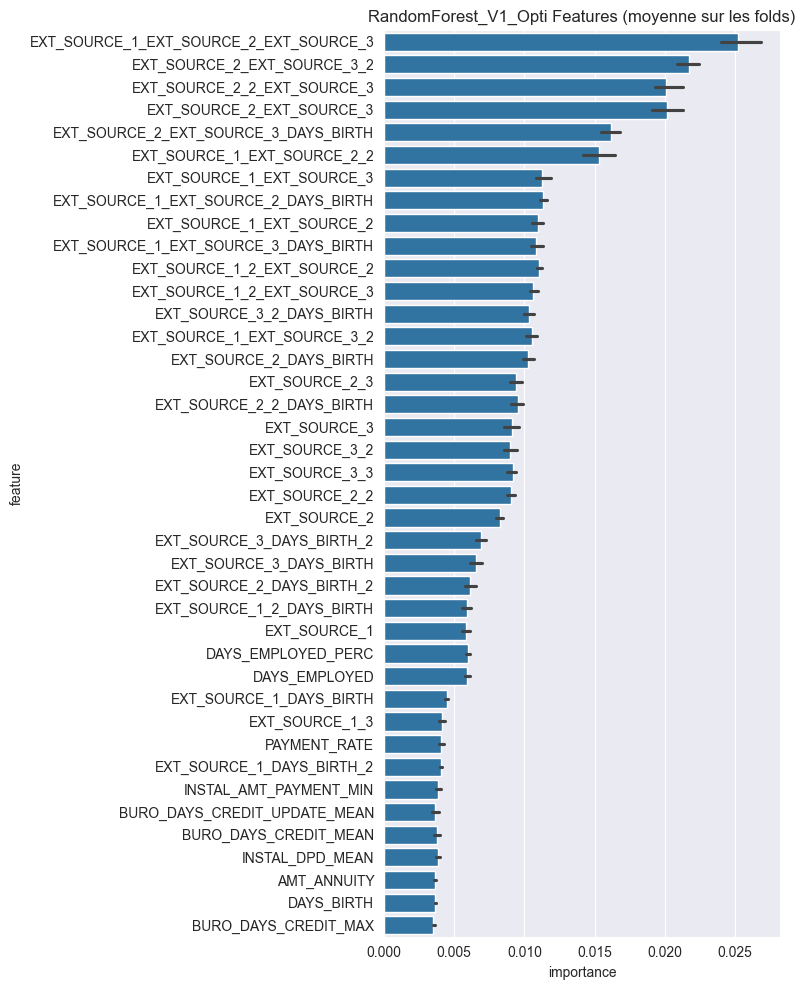

In [3]:
# ====================================================================
# 3. EXÉCUTION PRINCIPALE
# ====================================================================

def main():
    # Chargement du dataframe traité
    print("Chargement du DataFrame à partir de 'final_dataset.parquet'")
    df = pd.read_parquet('../data/final_dataset.parquet')

    # Choix du modèle
    modele_a_tester = "random_forest"

    if modele_a_tester == "logistic_regression":
        with timer("Exécution de la régression logistique"):
            kfold_logistic_regression(df, num_folds=5, stratified=False, debug=False)

    elif modele_a_tester == "lightgbm":
        with timer("Exécution de LightGBM avec kfold, score métier et MLflow"):
            kfold_lightgbm(df, num_folds=5, stratified=False, debug=False)

    elif modele_a_tester == "XGBoost":
        with timer("Execution de XGBoost avec kfold, score métier et MLflow"):
            kfold_xgboost(df, num_folds=5, stratified=False, debug=False)

    elif modele_a_tester == "random_forest":
        with timer("Execution de RandomForest avec kfold, score métier et MLflow"):
            kfold_random_forest(df, num_folds=5, stratified=False, debug=False)

if __name__ == "__main__":
    with timer("Exécution complète du modèle"):
        main()

| Modèle | Score AUC | Coût Métier Final | Seuil Optimal |
| :--- | :--- | :--- | :--- |
| **Régression Logistique** | 0.775 | N/A | 0.05 |
| **LightGBM (Baseline)** | **0.791** | 41 713 € | 0.04 |
| **LightGBM (Optimisé V1)** | 0.790 | **29 708 €** | 0.52 |
| **XGBoost (Baseline)** | 0.774 | 31 043 € | 0.52 |
| **XGBoost (Optimisé)** | 0.779 | 30 589 € | 0.52 |
| **Random Forest (Baseline)** | 0.751 | 33 013 € | 0.48 |
| **Random Forest (Optimisé)** | 0.752 | 32 846 € | 0.34 |



Après avoir comparé plusieurs modèles (Régression Logistique, Random Forest, XGBoost et LightGBM) en utilisant la validation croisée, nous avons sélectionné le modèle LightGBM optimisé (v1) comme modèle final. Bien qu'un autre modèle LightGBM ait obtenu un score AUC légèrement supérieur (0.791 contre 0.790), notre choix s'est porté sur la version optimisée en raison de son coût métier minimal. Avec un coût total de 29 708 €, ce modèle surpasse tous les autres en réduisant au maximum les pertes financières potentielles de l'entreprise. Cette sélection met en lumière l'importance d'utiliser une métrique métier pour guider les décisions, et non pas de se fier uniquement aux scores techniques comme l'AUC.